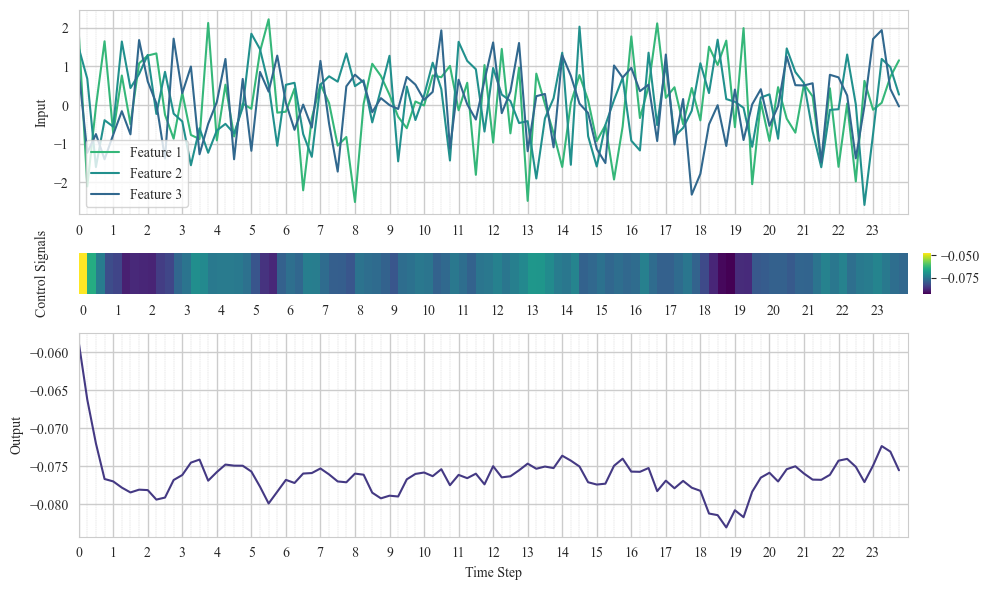

LSTM Hidden State Shape: (96, 64)


In [94]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')
colors = sns.color_palette("viridis_r", 5)

plt.rcParams['font.family'] = 'Times New Roman'

# Hook storage
lstm_outputs = None

# Define Hook Function
def hook_fn(module, input, output):
    global lstm_outputs
    lstm_outputs = output[0].detach().numpy().squeeze()  # Shape: (96, 64)

# Define LSTM Model with Hook
class LSTMModel(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=1, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # Register hook on LSTM layer
        self.lstm.register_forward_hook(hook_fn)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # Hook captures this output
        out = self.fc(lstm_out)     # Output shape: (batch, 96, 1)
        return out

# Generate random input (batch size = 1, 96 time steps, 3 features)
torch.manual_seed(42)
input_data = torch.randn(1, 96, 3)

# Initialize and run the model
model = LSTMModel()
output = model(input_data).detach().numpy().squeeze()  # Shape: (96,)

# Convert input data for visualization
input_data_np = input_data.numpy().squeeze()  # Shape: (96, 3)

# Plotting
minor_hours = np.arange(0, 24, 0.25)
major_hours = np.arange(0, 24, 1)

fig, axs = plt.subplots(3, 2, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 0.2, 1], 'width_ratios': [5, 0.05]})
axs = axs.flatten()
axs[1].set_visible(False)  # Hide empty subplot
axs[5].set_visible(False)  # Hide empty subplot

# 🟢 First subplot: 96x3 input as three separate line plots
for i in range(3):
    axs[0].plot(np.arange(96)/4, input_data_np[:, i], label=f'Feature {i+1}', color=colors[i+1])
axs[0].legend()
axs[0].set_ylabel("Input")
axs[0].set_xticks(minor_hours, minor=True)
axs[0].set_xticks(major_hours, minor=False)
axs[0].set_xlim(0, 24)
axs[0].grid(True, which='minor', linestyle='--', linewidth=0.3)
axs[0].grid(True, which='major', linestyle='-', linewidth=1)


# 🔵 Second subplot: Heatmap of 96x1 output
signal_df = pd.DataFrame([lstm_outputs[:,0]], columns=(np.arange(96)/4).astype(int))
signal_df.index = [" "]

sns.heatmap(signal_df, cmap="viridis", cbar=True, ax=axs[2], cbar_ax=axs[3], xticklabels=4)
axs[2].set_ylabel("Control Signals")
# axs[2].set_xticks(np.arange(0,24.25,1))

axs[4].plot(np.arange(96)/4, output, label="Output", color=colors[4])
axs[4].set_xlabel("Time Step")
axs[4].set_ylabel("Output")
axs[4].set_xticks(minor_hours, minor=True)
axs[4].set_xticks(major_hours, minor=False)


axs[4].set_xlim(0, 24)
axs[4].grid(True, which='minor', linestyle='--', linewidth=0.3)
axs[4].grid(True, which='major', linestyle='-', linewidth=1)


plt.tight_layout()
plt.show()

# ✅ `lstm_outputs` now holds the intermediate LSTM activations (96x64)
print("LSTM Hidden State Shape:", lstm_outputs.shape)  # (96, 64)

In [18]:
import torch
import torch.nn as nn

# Hook storage
intermediate_output = None

# Hook function to store intermediate activations
def hook_fn(module, input, output):
    global intermediate_output
    intermediate_output = output[0].detach()  # Store hidden states

# Define the same LSTM Model (must match the trained model structure)
class LSTMModel(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=1, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # Hook captures this output
        out = self.fc(lstm_out)
        return out

# Load trained model
model = LSTMModel()
# model.load_state_dict(torch.load("your_model.pth"))  # Load weights
model.eval()  # Set to evaluation mode

# Register hook on LSTM layer
model.lstm.register_forward_hook(hook_fn)

# Generate dummy input (same shape as training data)
input_data = torch.randn(1, 96, 3)  # Batch size = 1, 96 time steps, 3 features

# Run inference
with torch.no_grad():
    output = model(input_data)

# ✅ `intermediate_output` now holds the LSTM hidden states!
print("Extracted LSTM Hidden States Shape:", intermediate_output.shape)  # (1, 96, 64)


Extracted LSTM Hidden States Shape: torch.Size([1, 96, 64])
